<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Tue Jun 27 22:21:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   45C    P0    29W / 120W |    469MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code

2.0.1+cu117


## 1. What are 3 areas in industry where computer vision is currently being used?

1. self-driving car
2. Factory object detection
3. Weather Forecast

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

- model is trained to much to the train data, which means the model does not represent general case.
- an undesirable machine learning behavior that ooccurs when the machine learning model gives accurate predictions for training data but not for new data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

- make smaller data set, iterate less, increase learning rate, normalization
- cross-validation, data augmentation, L1/L2 regularization

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [16]:
# import all libaraies
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

import random

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision.datasets import FashionMNIST

In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

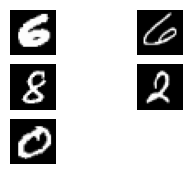

In [5]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(3, 2))
rows, cols = 3, 2
for i in range(1, rows * cols):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [6]:
train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

len(train_data_loader), len(test_data_loader)

(1875, 313)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [5]:
class MNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, outputshape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = 'valid' (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.blcok_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=outputshape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.blcok_2(x)
        x = self.classifier(x)
        return x

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss:{test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [9]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
# Train on cpu
device = "cpu"

torch.manual_seed(42)

# generate model instance
model_2_cpu = MNISTModelV2(input_shape=1,
                              hidden_units=10,
                              outputshape=len(train_data.classes))

# accuraccy function on cpu
acc_fn = Accuracy(task="multiclass",
                  num_classes=len(train_data.classes)).to(device)

optimizer = torch.optim.SGD(params=model_2_cpu.parameters(), lr=0.1)

epochs = 5

# record start time
start_time_cpu = time.time()

# train
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_2_cpu,
               dataloader=train_data_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=acc_fn,
               device=device)
    test_step(model=model_2_cpu,
              dataloader=test_data_loader,
              loss_fn=loss_fn,
              accuracy_fn=acc_fn,
              device=device)

# record end time
end_time_cpu = time.time()
print(f"train time taken on cpu: {end_time_cpu - start_time_cpu}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.27071 | Train accuracy: 0.91%
Test loss:0.08228 | Test accuracy: 0.97%

Epoch: 1
----------
Train loss: 0.06822 | Train accuracy: 0.98%
Test loss:0.04437 | Test accuracy: 0.99%

Epoch: 2
----------
Train loss: 0.05242 | Train accuracy: 0.98%
Test loss:0.04059 | Test accuracy: 0.98%

Epoch: 3
----------
Train loss: 0.04344 | Train accuracy: 0.99%
Test loss:0.04133 | Test accuracy: 0.99%

Epoch: 4
----------
Train loss: 0.03838 | Train accuracy: 0.99%
Test loss:0.03466 | Test accuracy: 0.99%

train time taken on cpu: 206.0633373260498


In [11]:
# Train on gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU is not available on this device")
    exit()

torch.manual_seed(42)

# model on gpu
model_2_gpu = MNISTModelV2(input_shape=1, hidden_units=10, outputshape=len(train_data.classes)).to(device)

acc_fn = Accuracy(task="multiclass",
                  num_classes=len(train_data.classes)).to(device)
optimizer = torch.optim.SGD(params=model_2_gpu.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 5

# record start time
start_time_gpu = time.time()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_2_gpu,
               dataloader=train_data_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=acc_fn,
               device=device)
    test_step(model=model_2_gpu,
              dataloader=test_data_loader,
              loss_fn=loss_fn,
              accuracy_fn=acc_fn,
              device=device)

# record end time
end_time_gpu = time.time()
print(f"Test time taken on gpu: {end_time_gpu - start_time_gpu}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.26612 | Train accuracy: 0.91%
Test loss:0.06944 | Test accuracy: 0.98%

Epoch: 1
----------
Train loss: 0.06669 | Train accuracy: 0.98%
Test loss:0.04256 | Test accuracy: 0.99%

Epoch: 2
----------
Train loss: 0.05217 | Train accuracy: 0.98%
Test loss:0.04597 | Test accuracy: 0.99%

Epoch: 3
----------
Train loss: 0.04317 | Train accuracy: 0.99%
Test loss:0.04092 | Test accuracy: 0.99%

Epoch: 4
----------
Train loss: 0.03861 | Train accuracy: 0.99%
Test loss:0.03274 | Test accuracy: 0.99%

Test time taken on gpu: 96.32001614570618


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

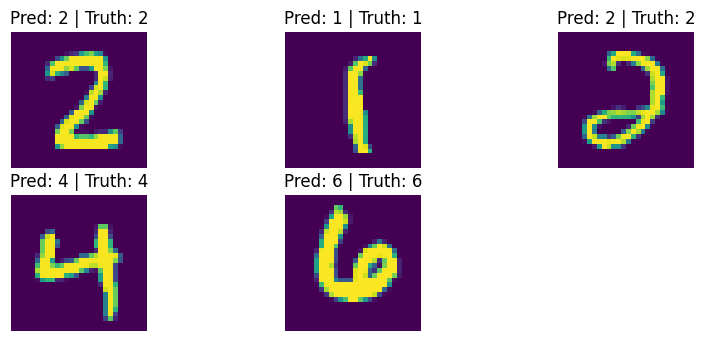

In [12]:
random.seed(42)

# pick 5 samples
samples = random.sample(list(range(len(test_data))), 5)

device = "cuda" if torch.cuda.is_available() else "cpu"

# get predictions and plot
plt.figure(figsize=(10, 6))
model_2_gpu.eval()

with torch.inference_mode():
    for i, sample in enumerate(samples):
        image, label = test_data[sample]
        
        pred_logits = model_2_gpu(image.unsqueeze(dim=0).to(device))
        pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
        pred_label = pred_prob.argmax()
        
        plt.subplot(3, 3, i+1)
        plt.imshow(image.squeeze())
        plt.title(f"Pred: {pred_label} | Truth: {label}")
        plt.axis(False)



## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [13]:
test_data.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

  0%|          | 0/313 [00:00<?, ?it/s]

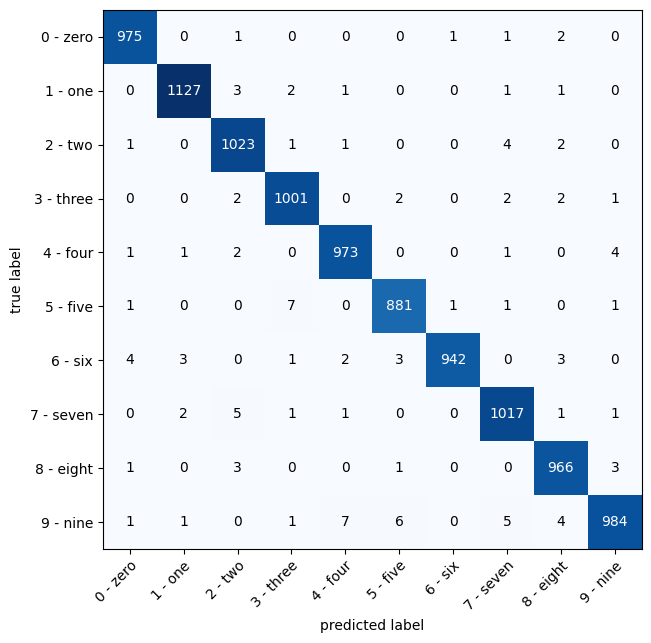

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# get predictions on test dataset
predictions = []
model_2_gpu.eval()
with torch.inference_mode():
    for X, y in tqdm(test_data_loader):
        X, y = X.to(device), y.to(device)

        y_label = torch.softmax(model_2_gpu(X), dim=1).argmax(dim=1)

        predictions.append(y_label.cpu())

y_pred_tensor = torch.cat(predictions)

# setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(test_data.classes),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [15]:
torch.manual_seed(42)

rand_tensor = torch.randn(size=(1, 3, 64, 64))
# print(rand_tensor)
# experiment with four kernels
kernels = [2, 3, 4, 5]

# random tensor

for kernel in kernels:
    # set conv 2d with given kernel size
    conv_2d = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=kernel, stride=1, padding=0)

    print(f"kernel size: {kernel} | output: {conv_2d(rand_tensor).shape}")

# if the kernel size increase -> output col and row decrease since bigger kernel means see more bigger area in one step 

kernel size: 2 | output: torch.Size([1, 10, 63, 63])
kernel size: 3 | output: torch.Size([1, 10, 62, 62])
kernel size: 4 | output: torch.Size([1, 10, 61, 61])
kernel size: 5 | output: torch.Size([1, 10, 60, 60])


## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [10]:
torch.manual_seed(42)

# setup GPU
device = "cuda" if torch.cuda.is_available else "cpu"
if device == "cpu":
    print("GPU cannot use on this device")
    exit()

# get data
train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# get dataloader
BATCH_SIZE = 32

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# model with 
model_3 = MNISTModelV2(
    input_shape=1,
    hidden_units=10,
    outputshape=10
).to(device)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# accuracy
acc_fn = Accuracy(task="multiclass",
                  num_classes=len(train_data.classes)).to(device)

# Train
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    
    model_3.train()

    train_loss, train_acc = 0, 0

    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)

        y_logits = model_3(X)

        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += acc_fn(torch.softmax(y_logits, dim=1).argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_data_loader)
    train_acc /= len(train_data_loader)

    model_3.eval()
    with torch.inference_mode():

        test_loss, test_acc = 0, 0

        for X, y in test_data_loader:
            X, y = X.to(device), y.to(device)

            test_logits = model_3(X)

            test_loss += loss_fn(test_logits, y)
            test_acc += acc_fn(torch.softmax(test_logits, dim=1).argmax(dim=1), y)

        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)
    
    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: {epoch}
----------
Epoch: 0 | Train loss: 0.57887, Train acc: 0.79% | Test loss: 0.38980, Test acc: 0.86%
Epoch: {epoch}
----------
Epoch: 1 | Train loss: 0.35633, Train acc: 0.87% | Test loss: 0.37397, Test acc: 0.86%
Epoch: {epoch}
----------
Epoch: 2 | Train loss: 0.31678, Train acc: 0.89% | Test loss: 0.32950, Test acc: 0.88%
Epoch: {epoch}
----------
Epoch: 3 | Train loss: 0.29548, Train acc: 0.89% | Test loss: 0.30626, Test acc: 0.89%
Epoch: {epoch}
----------
Epoch: 4 | Train loss: 0.28218, Train acc: 0.90% | Test loss: 0.30825, Test acc: 0.89%


In [20]:
torch.manual_seed(42)

# Evaluate
model_3.eval()

predictions = []

with torch.inference_mode():
    for X, y in test_data_loader:
        X, y = X.to(device), y.to(device)

        y_labels = torch.softmax(model_3(X), dim=1).argmax(dim=1)
        predictions.append(y_labels.cpu())

predictinos_tensor = torch.cat(predictions)
predictinos_tensor

tensor([9, 2, 1,  ..., 8, 1, 5])

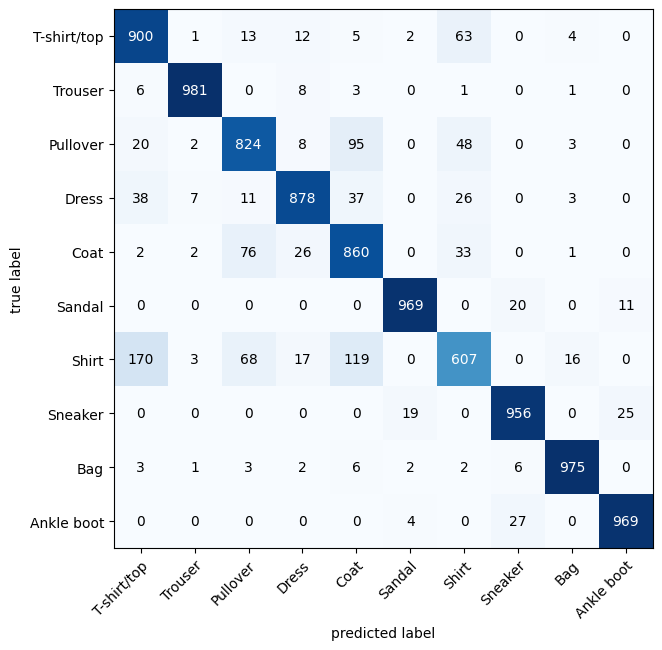

In [25]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(test_data.classes))
confmat = confmat(predictinos_tensor, test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
)

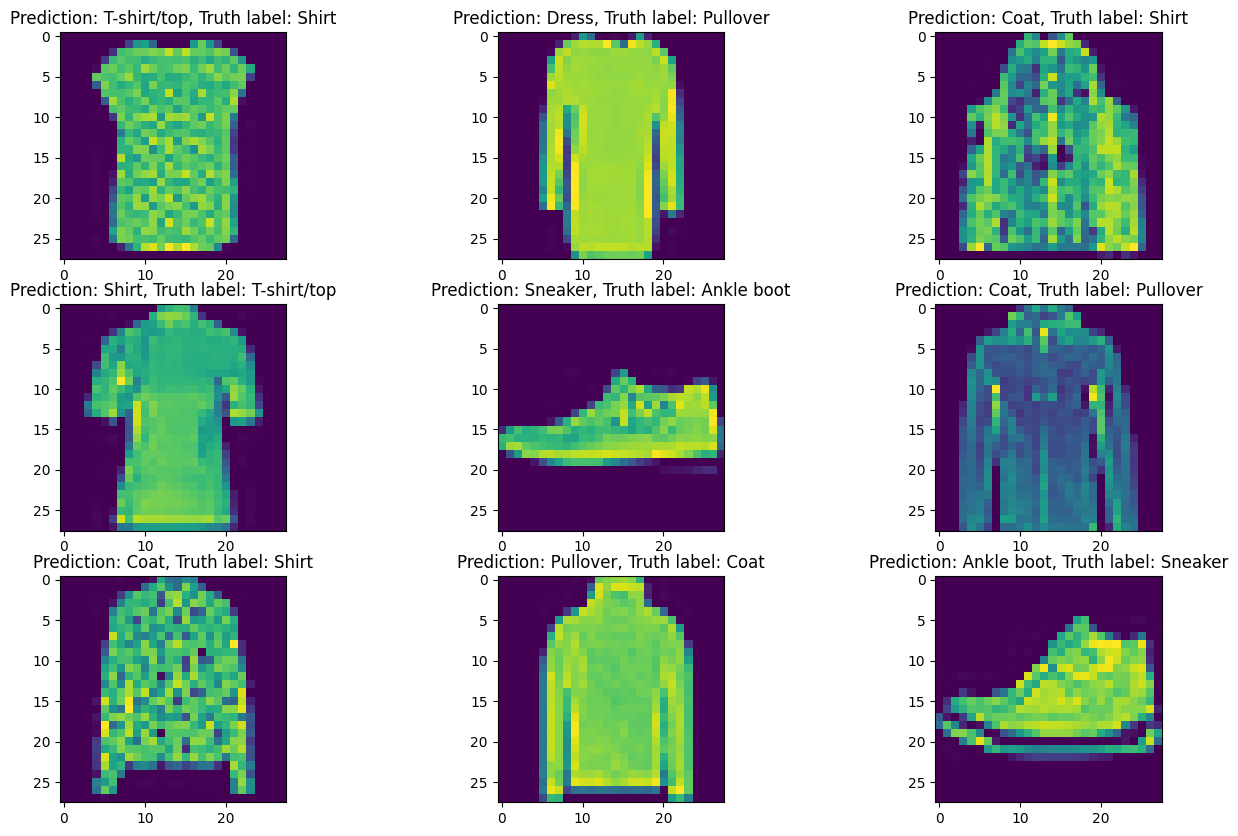

In [66]:
import numpy as np

# get wrong predictions
wrong_predictions_idx = np.where(test_data.targets != predictinos_tensor)[0]
# wrong_predictinos = test_data[wrong_predictions_idx[0]]

# plot 9 images which is classified wrongly
plt.figure(figsize=(16, 10))
for i in range(9):
    rand_index = random.choice(range(len(wrong_predictions_idx)))
    img, label = test_data[wrong_predictions_idx[rand_index]]
    predicted_label = test_data.classes[predictinos_tensor[wrong_predictions_idx[rand_index]]]
    plt.subplot(3, 3, i+1)
    plt.imshow(img.squeeze())
    plt.title(f"Prediction: {predicted_label}, Truth label: {test_data.classes[label]}")